In [1]:
from datetime import datetime, timedelta
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline
%config IPCompleter.greedy = True
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import xgboost as xgb

sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)

sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)
import requests
from creds import api_key

import tensorflow as tf
import tensorflow_probability as tfp
from pandasgui import show

tf.distribute.OneDeviceStrategy(device="/gpu:0")

In [2]:
def compile_lc_data(num_days=180, read_csv=False, write_csv=False, coins="ETH"):
    file = Path.cwd() / "lunar_histdata.csv"
    if read_csv is True:
        df = pd.read_csv(file, index_col=0)
        return df
    intervals = ["1d", "1w", "1m", "3m", "6m", "1y", "2y"]
    finish = datetime.now()
    start = finish - timedelta(days=num_days)
    delta = timedelta(hours=720)
    df = pd.DataFrame()
    while finish > start:
        payload = {
            "key": api_key,
            "symbol": coins,
            "change": intervals,
            "data_points": "720",
            "start": datetime.timestamp(start),
        }

        r = requests.get("https://api.lunarcrush.com/v2?data=assets", params=payload)

        data = pd.DataFrame.from_dict(r.json()["data"][0])
        ts = data.timeSeries.to_dict()
        new = pd.DataFrame.from_dict(ts, orient="index")
        new.pop("asset_id")
        new.pop("search_average")
        new["time"] = pd.to_datetime(new["time"], unit="s")
        new.set_index("time", inplace=True)
        new.sort_index(ascending=True, inplace=True)
        new["month"] = [new.index[i].month for i in range(len(new))]
        new["day"] = [new.index[i].day for i in range(len(new))]
        new["hour"] = [new.index[i].hour for i in range(len(new))]
        new.fillna(new.mean(), inplace=True)

        df = df.append(new, ignore_index=False, verify_integrity=True)
        start = start + delta

    if write_csv is True:
        df.to_csv(file)

    return df


df = compile_lc_data(read_csv=True)
print("NaN Check ")
print(df.isna().sum().sum())
print(df.index.max())
print(df.index.min())
print(len(df))
df.tail()


NaN Check 
0
2021-10-27 17:00:00
2021-04-30 18:00:00
4320


,open,close,high,low,volume,market_cap,url_shares,unique_url_shares,reddit_posts,reddit_posts_score,...,social_volume,price_btc,social_volume_global,social_dominance,market_cap_global,market_dominance,percent_change_24h,month,day,hour
time,,,,,,,,,,,,,,,,,,,,,
2021-10-27 13:00:00,4017.771623,3999.375920,4026.983646,3997.305227,1.194754e+09,472689468151,744,407,37.567529,468.939655,...,4618,0.067604,103925,4.443589,2706433014518,17.465404,-4.568263,10,27,13
2021-10-27 14:00:00,3999.166344,4021.947489,4041.576430,3982.374095,1.509966e+09,474989598384,937,459,37.567529,468.939655,...,5950,0.067774,121854,4.882893,2722139672515,17.449127,-3.212382,10,27,14
2021-10-27 15:00:00,4021.248990,4001.185048,4035.149027,3996.347556,1.203626e+09,471876484833,1026,439,37.567529,468.939655,...,5798,0.067809,130519,4.442265,2708389913267,17.422768,-4.554406,10,27,15
2021-10-27 16:00:00,4002.454009,3985.971390,4011.179803,3960.514271,1.518369e+09,471412791739,1070,527,37.567529,468.939655,...,6216,0.067478,135228,4.596681,2708682760745,17.403765,-4.470943,10,27,16
2021-10-27 17:00:00,3987.241219,3992.361146,4009.138146,3987.241219,4.311580e+08,471499670053,1092,511,37.567529,468.939655,...,5883,0.067599,113985,5.161205,2713845456123,17.373859,-5.490000,10,27,17


In [3]:
train_ds = df.sample(frac=0.8, random_state=0)
test_ds = df.drop(train_ds.index)

train_features = train_ds.copy()
test_features = test_ds.copy()

train_label = train_features.pop("close")
test_label = test_features.pop("close")


normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features).astype("float32"))

linear_model = tf.keras.models.Sequential([normalizer, tf.keras.layers.Dense(1)])
optimizer = tf.keras.optimizers.Adam()

linear_model.compile(optimizer=optimizer, loss="mse")


In [4]:
linear_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(58, 1) dtype=float32, numpy=
array([[-0.13431363],
       [-0.02248627],
       [ 0.05850875],
       [-0.13471758],
       [ 0.08368614],
       [-0.10091648],
       [ 0.00964206],
       [ 0.11618438],
       [-0.30137998],
       [ 0.27318376],
       [-0.30507225],
       [ 0.13857165],
       [ 0.28252894],
       [ 0.12130484],
       [ 0.02262798],
       [-0.16682859],
       [-0.01923132],
       [ 0.13068065],
       [ 0.11038408],
       [ 0.13377091],
       [-0.12102017],
       [-0.26626864],
       [-0.00827885],
       [ 0.279858  ],
       [-0.2836768 ],
       [-0.01773137],
       [-0.15258011],
       [ 0.274929  ],
       [ 0.02859876],
       [ 0.09423283],
       [-0.16087621],
       [-0.3114479 ],
       [ 0.1895346 ],
       [-0.16268004],
       [ 0.07192153],
       [-0.0808714 ],
       [ 0.13420665],
       [ 0.1959303 ],
       [ 0.2027371 ],
       [ 0.3054061 ],
       [ 0.1912502 ],
       [ 0.22121489],
       [-0

In [5]:
%%time
early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=4, mode="min"
    )
history = linear_model.fit(
    train_features,
    train_label,
    epochs=2000,
    validation_split=.2,
    callbacks=[early_stopping],
    
)

Epoch 1/2000
87/87 [==============================] - 2s 8ms/step - loss: 9061316.0000 - val_loss: 9292571.0000
Epoch 2/2000
87/87 [==============================] - 0s 5ms/step - loss: 9060112.0000 - val_loss: 9291086.0000
Epoch 3/2000
87/87 [==============================] - 0s 6ms/step - loss: 9058895.0000 - val_loss: 9289721.0000
Epoch 4/2000
87/87 [==============================] - 1s 6ms/step - loss: 9057686.0000 - val_loss: 9288300.0000
Epoch 5/2000
87/87 [==============================] - 0s 5ms/step - loss: 9056479.0000 - val_loss: 9286889.0000
Epoch 6/2000
87/87 [==============================] - 0s 5ms/step - loss: 9055273.0000 - val_loss: 9285459.0000
Epoch 7/2000
87/87 [==============================] - 0s 5ms/step - loss: 9054068.0000 - val_loss: 9284027.0000
Epoch 8/2000
87/87 [==============================] - 0s 5ms/step - loss: 9052865.0000 - val_loss: 9282596.0000
Epoch 9/2000
87/87 [==============================] - 0s 5ms/step - loss: 9051663.0000 - val_loss: 92811

In [6]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.tail()


,loss,val_loss,epoch
1995,7693166.0,7802297.5,1995
1996,7692652.5,7801797.0,1996
1997,7692145.5,7801267.0,1997
1998,7691629.5,7800789.0,1998
1999,7691127.0,7800269.0,1999


In [7]:
test_results = {}

test_results["linear_baseline"] = linear_model.evaluate(
    test_features, test_label, verbose=0
)


In [8]:
def build_and_compile_model(norm):
    model = tf.keras.models.Sequential(
        [
            norm,
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(1),
        ]
    )
    model.compile(
        loss="mse", optimizer="adam", metrics=[tf.metrics.MeanAbsoluteError()]
    )
    return model


In [9]:
dnn_model = build_and_compile_model(normalizer)

dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 58)                117       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                3776      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 8,118
Trainable params: 8,001
Non-trainable params: 117
_________________________________________________________________


In [10]:
%%time
history = dnn_model.fit(
    train_features,
    train_label,
    validation_split=0.2,
    epochs=2000, callbacks=[early_stopping])

Epoch 1/2000
87/87 [==============================] - 1s 7ms/step - loss: 8981285.0000 - mean_absolute_error: 2923.2644 - val_loss: 9008968.0000 - val_mean_absolute_error: 2929.6611
Epoch 2/2000
87/87 [==============================] - 0s 5ms/step - loss: 8000555.0000 - mean_absolute_error: 2751.4326 - val_loss: 6967678.0000 - val_mean_absolute_error: 2559.5283
Epoch 3/2000
87/87 [==============================] - 0s 5ms/step - loss: 4977300.0000 - mean_absolute_error: 2091.3530 - val_loss: 3419422.7500 - val_mean_absolute_error: 1678.6096
Epoch 4/2000
87/87 [==============================] - 0s 6ms/step - loss: 2409067.2500 - mean_absolute_error: 1356.7600 - val_loss: 1885042.1250 - val_mean_absolute_error: 1196.6982
Epoch 5/2000
87/87 [==============================] - 1s 6ms/step - loss: 1561783.0000 - mean_absolute_error: 1061.2186 - val_loss: 1375477.8750 - val_mean_absolute_error: 997.4456
Epoch 6/2000
87/87 [==============================] - 0s 6ms/step - loss: 1195078.1250 - me

<AxesSubplot:xlabel='epoch'>

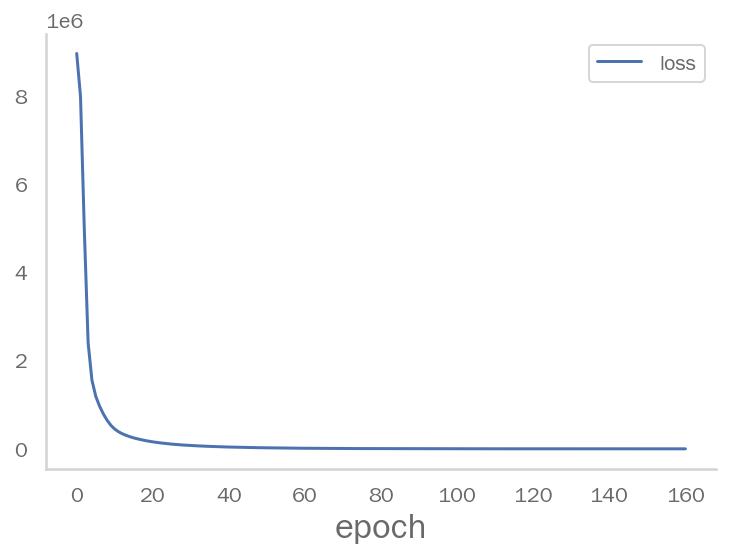

In [11]:
hist = pd.DataFrame(history.history)
hist["epoch"] = history.epoch
hist.plot(x="epoch", y="loss")


In [12]:
test_results["dnn_model"] = dnn_model.evaluate(test_features, test_label)

print(test_results)


27/27 [==============================] - 0s 3ms/step - loss: 2581.0327 - mean_absolute_error: 27.6908
{'linear_baseline': 7722508.5, 'dnn_model': [2581.03271484375, 27.690780639648438]}


In [13]:
test_predictions = {}
test_predictions["dnn_model"] = dnn_model.predict(test_features).flatten()


In [14]:
dtrain = xgb.DMatrix(train_features, label=train_label)
dtest = xgb.DMatrix(test_features, label=test_label)

param = {"max_depth": 50, "eta": 1, "objective": "reg:squarederror", "booster": "gbtree"}
evallist = [(dtest, "eval"), (dtrain, "train")]

num_round = 2
xg = xgb.train(param, dtrain, num_round, evallist)

[09:08:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[0]	eval-rmse:97.33028	train-rmse:94.79799
[1]	eval-rmse:21.15627	train-rmse:13.05729


In [15]:
test_results["xgb"] = xg.evaluate(test_features, test_label)

print(test_results)

AttributeError: 'Booster' object has no attribute 'evaluate'

In [ ]:
test_predictions["xgb"] = xg.predict(test_features).flatten()

print(test_predictions)


In [ ]:
# def conv_model(normalizer):
#     CONV_WIDTH = 3

#     model = tf.keras.models.Sequential(
#         [
#             normalizer,
#             # tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
#             # tf.keras.layers.Conv1D(
#             #     filters=64,
#             #     kernel_size=(CONV_WIDTH),
#             #     strides=1,
#             #     padding="causal",
#             #     # activation="relu",
#             # ),
#             tf.keras.layers.Bidirectional(
#                 tf.keras.layers.LSTM(128, return_sequences=False)
#             ),
#             # tf.keras.layers.Bidirectional(
#             #     tf.keras.layers.LSTM(64, return_sequences=True)),
#             tf.keras.layers.Dense(128),
#             tf.keras.layers.Dropout(0.2),
#             tf.keras.layers.Dense(1),
#         ]
#     )

#     model.compile(
#         loss="mse", optimizer="adam", metrics=[tf.metrics.MeanAbsoluteError()]
#     )

#     return model


In [ ]:
# conv_model = conv_model(normalizer)

# conv_model.summary()


In [ ]:
# %%time
# history = conv_model.fit(
#     train_features,
#     train_label,
#     validation_split=0.2,
#     epochs=2000, callbacks=[early_stopping])

In [ ]:
# test_results["conv_model"] = dnn_model.evaluate(test_features, test_label)

# print(test_results)


In [ ]:
# test_predictions["conv_model"] = dnn_model.predict(test_features).flatten()

# print(test_predictions)


In [ ]:
def plot_result(labels, preds):
    plt.figure(figsize=(15, 10))
    plt.scatter(x=labels.index, y=labels, color="r", marker=".", label="real data")
    plt.scatter(x=labels.index, y=preds, color="b", marker="X", label="predictions")
    plt.xlabel("time")
    plt.ylabel("price")
    plt.title("Red is predictions, Blue is real data")
    plt.show()


In [ ]:
plot_result(test_label, test_predictions["dnn_model"])

In [ ]:
plot_result(test_label, test_predictions["xgb"])
